<a href="https://colab.research.google.com/github/pal-ette/iNotePal/blob/7-conv/%EB%8B%A8%EB%B0%9C%EC%84%B1%EB%8C%80%ED%99%94%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# matplotlib Korean
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install gluonnlp==0.10.0

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
# pycospacing 한국어 띄어쓰기
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook

In [3]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [4]:
device = torch.device("cuda:0")

In [5]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

# Load Data

In [6]:
root = '/content/drive/MyDrive/iNotePal/감정대화데이터셋'

conti = os.path.join(root, 'continuous.xlsx')
short = os.path.join(root, 'short.xlsx')

In [7]:
df_conti = pd.read_excel(conti, header=1, usecols=['dialog #', '발화', '감정'])
df_conti.columns = ['start', 'sentence', 'emotion']
df_short = pd.read_excel(short, usecols=['Sentence', 'Emotion']).rename(columns=str.lower)

In [8]:
emotion = df_short.groupby(['emotion']).count()
emotion = emotion.index.tolist()
emotion

['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오']

### Preprocessing 1
- 잘못된 라벨 수정
- missing value handling

In [9]:
df_conti['emotion'] = df_conti['emotion'].fillna(value='중립')

In [10]:
df_conti = df_conti.dropna(subset = ['sentence']).reset_index(drop=True)

In [11]:
wrong_labeled = df_conti[~df_conti['emotion'].isin(emotion)]
idx_p = wrong_labeled[wrong_labeled['emotion']=='ㅍ'].index

In [12]:
for i in idx_p.tolist():
  df_conti['emotion'][i] = '중립'

In [13]:
wrong_labeled = wrong_labeled = df_conti[~df_conti['emotion'].isin(emotion)].index

for i in wrong_labeled:
  if '중' in df_conti['emotion'][i] or '줄' in df_conti['emotion'][i]:
    df_conti['emotion'][i] = '중립'
  if '분' in df_conti['emotion'][i]:
    df_conti['emotion'][i] = '분노'

In [14]:
df_conti[~df_conti['emotion'].isin(emotion)]

,start,sentence,emotion


In [15]:
df_conti

,start,sentence,emotion
0,S,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데!,분노
1,NaN,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고.,혐오
2,NaN,손님 왔어요.,중립
3,NaN,손님? 누구?,중립
4,NaN,몰라요. 팀장님 친구래요.,중립
...,...,...,...
55622,S,얘긴 다 끝났냐? 원예부,중립
55623,NaN,"예. 그거 때문에, 부탁이 있......는......데요.",중립
55624,NaN,여자 숨겨달라는거면 사절이다.,중립
55625,NaN,아무래도 안되나요?,중립


### Preprocessing 2
- 대화 나누기
```
A : sentence 1, emotion 1
B : sentence 2, emotion 2
A : sentence 3, emotion 3
B : sentence 4, emotion 4
==> sentence 1 + sentence 2, emotion 2
      sentence 2 + sentence 3, emotion 3
      sentence 3 + sentence 4, emotion 4
```

In [16]:
conv, emo = [], []

for row in df_conti.itertuples():

  if row.Index+1 == len(df_conti) or df_conti['start'][row.Index+1] == 'S':
    continue

  merge_sentence = row.sentence + ' ' + df_conti['sentence'][row.Index+1]
  conv.append(merge_sentence)
  emo.append(df_conti['emotion'][row.Index+1])

In [17]:
df_conti_merged = pd.DataFrame({"sentence":conv, "emotion": emo})
df_conti_merged

,sentence,emotion
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오
1,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. 손...,중립
2,손님 왔어요. 손님? 누구?,중립
3,손님? 누구? 몰라요. 팀장님 친구래요.,중립
4,몰라요. 팀장님 친구래요. 내 친구? 친구 누구?,중립
...,...,...
45622,"증거를 못 찾아도 적당히 단정하라 이거야? 뭐, 대충 그런 의미네.",중립
45623,"얘긴 다 끝났냐? 원예부 예. 그거 때문에, 부탁이 있......는......데요.",중립
45624,"예. 그거 때문에, 부탁이 있......는......데요. 여자 숨겨달라는거면 사절이다.",중립
45625,여자 숨겨달라는거면 사절이다. 아무래도 안되나요?,중립


In [18]:
df_conti['emotion'].value_counts()

emotion
중립    43808
놀람     4866
분노     3633
슬픔     1972
행복     1030
혐오      220
공포       98
Name: count, dtype: int64

In [19]:
df_conti_merged['emotion'].value_counts()

emotion
중립    35886
놀람     3857
분노     3030
슬픔     1712
행복      879
혐오      182
공포       81
Name: count, dtype: int64

In [20]:
df_short['emotion'].value_counts()

emotion
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: count, dtype: int64

### Preprocessing 3
- 행복 > 기쁨 re-labelling

In [21]:
df_short['emotion'] = df_short['emotion'].replace('행복', '기쁨')
df_short[df_short['emotion']=='기쁨']

,sentence,emotion
27128,유재석 오라버니 해피투게더 봤어요,기쁨
27129,우리모두 준혁이성과 LG선수들이 선전할수 있게 기를 넣어줍시다.,기쁨
27130,웃긴거 알죠?~ㅋㅋㅇ ㅏ~,기쁨
27131,덕분에 주방에서 요리하는게 넘 좋아졌어요,기쁨
27132,마지막 순간 손가락으로 총을 만들어 쏘실때에는 제가 직접 맞는 것 같습니다.,기쁨
...,...,...
33160,유느님 내일 이면 해피투게더가하네요~^^,기쁨
33161,승관아~ 너에게 편지를 안 쓸 수가 없네.,기쁨
33162,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,기쁨
33163,유재석 오라버니 해피투게더 해피파출소 편 봤어요,기쁨


In [22]:
df_conti_merged['emotion'] = df_conti_merged['emotion'].replace('행복', '기쁨')
df_conti_merged[df_conti_merged['emotion']=='기쁨']

,sentence,emotion
20,나 이런 거 한번도 안 해봤어. 잘됐네. 그럼 이번에 해보면 되잖아.,기쁨
146,미국 어디? 뉴욕이요. 가서 저는 공부하고. 오빠는 취업하기로. 운이 좋았어요.,기쁨
147,뉴욕이요. 가서 저는 공부하고. 오빠는 취업하기로. 운이 좋았어요. 야... 잘됐네...,기쁨
220,나중에 이런데다 집 짓고 살거야. 그때 니가 지어줘. 꽁짜로. 알았지? 당연하지!,기쁨
255,근데 왜? ... 기특해서. 귀여워서.,기쁨
...,...,...
45189,"그, 그러게……. 아, 그럼 하나~ 둘~ 세고 끊는 건 어때?",기쁨
45209,"……비싸네. 우와, 비싸! ……엄청 비싸다. 하긴 남자애니까. 별로 관심 없으려나?...",기쁨
45211,으……. 이럴 땐 진짜 질색하는 표정이 된다니깐. 감탄스럽기까지 해.,기쁨
45213,커플룩이라면 저랑 입는 것보단 사이좋은 자매끼리 입는 게 훨씬 귀엽게 보이겠죠. 너...,기쁨


In [54]:
df_conti_merged['dataset'] = ['conversation']*len(df_conti_merged)
df_short['dataset'] = ['comment']*len(df_short)

df = pd.concat([df_conti_merged, df_short], ignore_index=True)
df

,sentence,emotion,dataset
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오,conversation
1,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. 손...,중립,conversation
2,손님 왔어요. 손님? 누구?,중립,conversation
3,손님? 누구? 몰라요. 팀장님 친구래요.,중립,conversation
4,몰라요. 팀장님 친구래요. 내 친구? 친구 누구?,중립,conversation
...,...,...,...
84216,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오,comment
84217,재미가 없으니 망하지,혐오,comment
84218,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오,comment
84219,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오,comment


In [24]:
emotion = df.groupby(['emotion']).count()

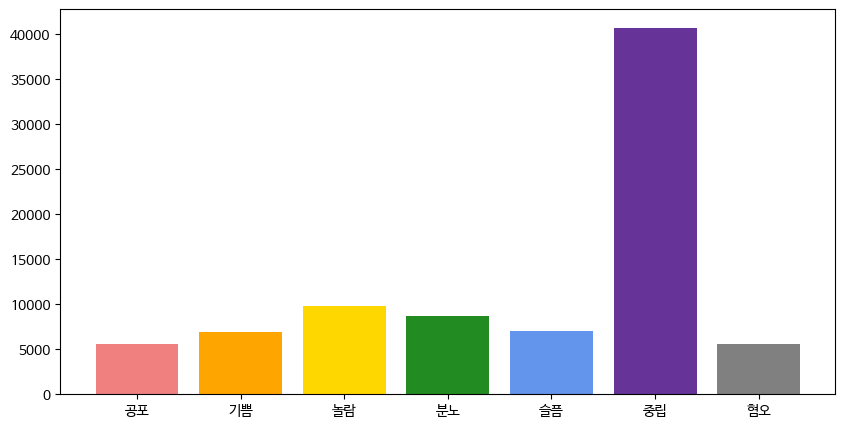

In [25]:
plt.rc('font', family='NanumBarunGothic')
colors = ['lightcoral', 'orange', 'gold', 'forestgreen', 'cornflowerblue', 'rebeccapurple', 'gray']

plt.figure(figsize=(10, 5))
plt.bar(emotion.index, emotion['sentence'], color=colors)
# plt.legend(cmap)

plt.show()

# Data Preprocessing

following [seona.log](https://velog.io/@fhflwhwl5/Python-KoBERT-7%EA%B0%80%EC%A7%80-%EA%B0%90%EC%A0%95%EC%9D%98-%EB%8B%A4%EC%A4%91%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0)

- Label Encoding
- Tokenization
```diff
? Remove extra characters
? word spacing
? without / with 중립
```

In [ ]:
import re

def preprocessing(text):
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', text)

In [58]:
df_except_neutral = df[df['emotion'] != '중립']
df_except_neutral

,sentence,emotion,dataset
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오,conversation
5,내 친구? 친구 누구? 그걸 내가 어떻게 알아요!,분노,conversation
12,남편은 뭐하는데? 동사무소에서 인구조사 나왔니? 지금.,분노,conversation
13,언제부터 시작할 수 있어? 나? ... 나보고 하라고?,놀람,conversation
14,나? ... 나보고 하라고? 그럼 내가 널 왜 만나러 왔겠어?,혐오,conversation
...,...,...,...
84216,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오,comment
84217,재미가 없으니 망하지,혐오,comment
84218,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오,comment
84219,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오,comment


In [59]:
df_except_neutral.reset_index(inplace=True, drop=True)
df_except_neutral

,sentence,emotion,dataset
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오,conversation
1,내 친구? 친구 누구? 그걸 내가 어떻게 알아요!,분노,conversation
2,남편은 뭐하는데? 동사무소에서 인구조사 나왔니? 지금.,분노,conversation
3,언제부터 시작할 수 있어? 나? ... 나보고 하라고?,놀람,conversation
4,나? ... 나보고 하라고? 그럼 내가 널 왜 만나러 왔겠어?,혐오,conversation
...,...,...,...
43500,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오,comment
43501,재미가 없으니 망하지,혐오,comment
43502,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오,comment
43503,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오,comment


In [60]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_except_neutral['label'] = LE.fit_transform(df_except_neutral['emotion'])

labels = LE.classes_
df_except_neutral.head()

<ipython-input-60-6d95e31af2b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_except_neutral['label'] = LE.fit_transform(df_except_neutral['emotion'])


,sentence,emotion,dataset,label
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는...,혐오,conversation,5
1,내 친구? 친구 누구? 그걸 내가 어떻게 알아요!,분노,conversation,3
2,남편은 뭐하는데? 동사무소에서 인구조사 나왔니? 지금.,분노,conversation,3
3,언제부터 시작할 수 있어? 나? ... 나보고 하라고?,놀람,conversation,2
4,나? ... 나보고 하라고? 그럼 내가 널 왜 만나러 왔겠어?,혐오,conversation,5


In [62]:
data_list = []
for q, label in zip(df_except_neutral['sentence'], df_except_neutral['label']):
  data = []
  data.append(q)
  data.append(label)
  data_list.append(data)
data_list[:5]

[['아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고.',
  5],
 ['내 친구? 친구 누구? 그걸 내가 어떻게 알아요!', 3],
 ['남편은 뭐하는데? 동사무소에서 인구조사 나왔니? 지금.', 3],
 ['언제부터 시작할 수 있어? 나? ... 나보고 하라고?', 2],
 ['나? ... 나보고 하라고? 그럼 내가 널 왜 만나러 왔겠어?', 5]]

In [91]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_list, test_size=0.25, random_state=0, shuffle=True)

print(len(train), len(test))

32628 10877


In [ ]:
df_except_neutral['sentence']

In [131]:
transform = nlp.data.BERTSentenceTransform(
            tok, max_seq_length=32, vocab=vocab, pad=True, pair=False)
transform(['언제부터 시작할 수 있어? 나? ... 나보고 하라고?'])

(array([   2, 3245, 6410, 2986, 7836, 2872, 3868,  258, 1370,  258,  517,
          55, 1370, 6366,  517, 7805,  258,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       dtype=int32),
 array(18, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [165]:
max_len = 100
batch_size = 16
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [166]:
class BERTDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [167]:
tok = tokenizer.tokenize

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

In [155]:
max_len = 294

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_test = [d[1] for d in testset]

In [156]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_test), max(token_len_test))

4 294
4 215


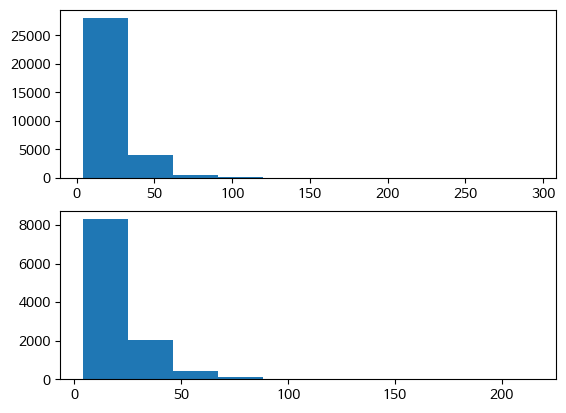

In [164]:
fig, ax = plt.subplots(2, 1)

ax[0].hist(token_len_train)
ax[1].hist(token_len_test)

plt.show()

In [168]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

In [169]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [170]:
model = BERTClassifier(bertmodel, dr_rate=0.4).to(device)

In [171]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [172]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [173]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-174-0c8f9eaadf59>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/2040 [00:00<?, ?it/s]

# Model Evaluation

In [ ]:
def predict(predict_sentence, model, labels):

    data = [predict_sentence]
    label = [0]

    dataset = BERTDataset(data, label, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            print(f'Prediction result : {labels[np.argmax(logits)]}')